import pandas as pd

df = pd.read_csv("./data/subject-info.csv", sep=";", encoding="utf-8")
df.head()

In [36]:
import pandas as pd

df = pd.read_csv("./data/subject-info_cleaned_2.csv", sep=";", encoding="utf-8")
df.head()

,Patient ID,Follow-up period from enrollment (days),days_4years,Exit of the study,Cause of death,Age,Gender (male=1),Weight (kg),Height (cm),Body Mass Index (Kg/m2),...,Angiotensin-II receptor blocker (yes=1),Anticoagulants/antitrombotics (yes=1),Betablockers (yes=1),Digoxin (yes=1),Loop diuretics (yes=1),Spironolactone (yes=1),Statins (yes=1),Hidralazina (yes=1),ACE inhibitor (yes=1),Nitrovasodilator (yes=1)
0,P0001,2065,1460,NaN,0,58,1,83,163,"31,2",...,0,1,1,1,1,0,0,0,1,0
1,P0002,2045,1460,NaN,0,58,1,74,160,"28,9",...,1,1,1,0,0,0,1,0,0,0
2,P0003,2044,1460,NaN,0,69,1,83,174,"27,4",...,1,1,1,1,1,0,0,0,0,0
3,P0004,2044,1460,NaN,0,56,0,84,165,"30,9",...,1,1,1,0,1,1,0,0,0,0
4,P0005,2043,1460,NaN,0,70,1,97,183,29,...,0,1,1,0,1,0,1,0,1,1



print("Spalten vor der Verarbeitung:", df.columns.tolist())

if "Average RR (ms)" in df.columns:
    print("Vorher:", df["Average RR (ms)"].head())


df["Average RR (ms)"].head()

In [37]:
print(df.columns[df.columns.duplicated(keep=False)])


Index([], dtype='object')


if isinstance(df["Average RR (ms)"], pd.DataFrame):
    print("✅ Die Spalte ist ein DataFrame mit mehreren Spalten.")
    print(df["Average RR (ms)"].head())  # Zeigt die ersten Zeilen der beiden Spalten
else:
    print("❌ Die Spalte ist KEIN DataFrame mit mehreren Spalten.")
    print("Datentyp:", type(df["Average RR (ms)"]))



if "Average RR (ms)" in df.columns:
    print(df["Average RR (ms)"].head())
    print(df["Average RR (ms)"].shape)  # Zeigt, ob es zwei Spalten gibt


In [38]:
print(df.dtypes)


Patient ID                                  object
Follow-up period from enrollment (days)      int64
days_4years                                  int64
Exit of the study                          float64
Cause of death                               int64
                                            ...   
Spironolactone (yes=1)                       int64
Statins (yes=1)                              int64
Hidralazina (yes=1)                          int64
ACE inhibitor (yes=1)                        int64
Nitrovasodilator (yes=1)                     int64
Length: 103, dtype: object


In [39]:
import pandas as pd
import numpy as np

# 🔹 Funktion zur vollständigen Datenbereinigung
def clean_data(df):
    print("\n🔷 Starte Datenbereinigung...")

    # 🔹 1. Entferne doppelte Spaltennamen, falls vorhanden
    df = df.loc[:, ~df.columns.duplicated()].copy()

    # 🔹 2. Falls 'Average_RR_ms' zwei Spalten enthält, korrekt aufteilen
    if "Average_RR_ms" in df.columns:
        if isinstance(df["Average_RR_ms"], pd.DataFrame):
            df["Average_RR_1_ms"] = df["Average_RR_ms"].iloc[:, 0]
            df["Average_RR_2_ms"] = df["Average_RR_ms"].iloc[:, 1]
            df.drop(columns=["Average_RR_ms"], inplace=True)
            print("✅ 'Average_RR_ms' erfolgreich aufgeteilt in zwei Spalten!")

    # 🔹 3. Identifiziere problematische numerische Spalten
    problematic_columns = df.select_dtypes(include=['object']).columns.tolist()

    # 🔹 4. Entferne nicht-numerische Spalten aus der Konvertierungsliste
    exclude_columns = ["Patient_ID", "Holter_onset_hhmmss"]
    convertible_columns = [col for col in problematic_columns if col not in exclude_columns]

    # 🔹 5. Ersetze Kommas durch Punkte und konvertiere nur echte numerische Werte
    for col in convertible_columns:
        if df[col].dtype == "object":  # Sicherstellen, dass die Spalte Strings sind
            try:
                df[col] = df[col].astype(str)  # Sicherstellen, dass es Strings sind
                df[col] = df[col].str.replace(",", ".", regex=True)  # Kommas durch Punkte ersetzen
                df[col] = df[col].str.replace(r"[^0-9.]", "", regex=True)  # Entferne nicht-numerische Zeichen außer Punkten
                df[col] = pd.to_numeric(df[col], errors="coerce")  # Konvertiere zu Float, setze Fehler auf NaN
                print(f"✅ Spalte {col} erfolgreich konvertiert.")
            except ValueError:
                print(f"⚠️ Spalte {col} konnte nicht konvertiert werden und bleibt im Originalformat.")
        else:
            print(f"ℹ️ Spalte {col} ist bereits numerisch und wird übersprungen.")

    print(f"✅ Erfolgreich konvertierte Spalten: {convertible_columns}")
    print(f"⚠️ Nicht konvertierte Spalten (enthielten Text): {exclude_columns}")

    # 🔹 6. Fehlende Werte behandeln
    missing_values = df.isnull().sum()
    high_missing = missing_values[missing_values > 0.3 * len(df)].index.tolist()
    if high_missing:
        print(f"⚠️ Entferne Spalten mit >30% fehlenden Werten: {high_missing}")
        df.drop(columns=high_missing, inplace=True)
    else:
        print("✅ Keine Spalten mit zu vielen fehlenden Werten.")

    df.fillna(df.median(numeric_only=True), inplace=True)

    # 🔹 7. Spaltennamen bereinigen
    df.columns = (df.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)  # Ersetze Leerzeichen durch Unterstriche
        .str.replace(r"[^A-Za-z0-9_]", "", regex=True)  # Entferne Sonderzeichen
        .str.replace(r"_+", "_", regex=True)  # Ersetze mehrere Unterstriche durch einen
    )

    print("✅ Spaltennamen bereinigt!")

    print("\n✅ Datenbereinigung abgeschlossen!")
    return df

# 🔹 Bereinigte Daten abrufen
df = clean_data(df)



🔷 Starte Datenbereinigung...
✅ Spalte Patient ID erfolgreich konvertiert.
✅ Spalte Age erfolgreich konvertiert.
✅ Spalte Body Mass Index (Kg/m2) erfolgreich konvertiert.
✅ Spalte Albumin (g/L) erfolgreich konvertiert.
✅ Spalte Normalized Troponin erfolgreich konvertiert.
✅ Spalte Total Cholesterol (mmol/L) erfolgreich konvertiert.
✅ Spalte Gamma-glutamil transpeptidase (IU/L) erfolgreich konvertiert.
✅ Spalte Glucose (mmol/L) erfolgreich konvertiert.
✅ Spalte Hemoglobin (g/L) erfolgreich konvertiert.
✅ Spalte HDL (mmol/L) erfolgreich konvertiert.
✅ Spalte Potassium (mEq/L) erfolgreich konvertiert.
✅ Spalte LDL (mmol/L) erfolgreich konvertiert.
✅ Spalte Protein (g/L) erfolgreich konvertiert.
✅ Spalte T3 (pg/dL) erfolgreich konvertiert.
✅ Spalte T4 (ng/L) erfolgreich konvertiert.
✅ Spalte Troponin (ng/mL) erfolgreich konvertiert.
✅ Spalte TSH (mIU/L) erfolgreich konvertiert.
✅ Spalte Urea (mg/dL) erfolgreich konvertiert.
✅ Spalte Cardiothoracic ratio erfolgreich konvertiert.
✅ Spalte Ho

print(type(df["Average_RR_1_ms"]))
print(type(df["Average_RR_2_ms"]))

print(df[["Average_RR_1_ms", "Average_RR_2_ms"]].head())


print("Nachher:", df[["Average_RR_1_ms", "Average_RR_2_ms"]].head())


In [40]:
print("\n🔍 **Finale Datenstrukturprüfung**")

# 1️⃣ Anzahl der Zeilen und Spalten anzeigen
print(f"📌 **Anzahl der Zeilen:** {df.shape[0]}")
print(f"📌 **Anzahl der Spalten:** {df.shape[1]}")

# 2️⃣ Datentypen überprüfen
print("\n📌 **Datentypen nach der Bereinigung:**")
print(df.dtypes.value_counts())

# 3️⃣ Fehlende Werte prüfen
missing_values = df.isnull().sum()
missing_values_sorted = missing_values[missing_values > 0].sort_values(ascending=False)
print("\n📌 **Fehlende Werte nach der Bereinigung:**")
print(missing_values_sorted if not missing_values_sorted.empty else "✅ Keine fehlenden Werte!")

# 4️⃣ Die ersten Zeilen des DataFrames anzeigen
print("\n📌 **Erste 5 Zeilen der bereinigten Daten:**")
print(df.head())

# 5️⃣ Prüfen, ob noch kategorische Variablen vorhanden sind
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("\n📌 **Kategorische Spalten im DataFrame:**")
print(categorical_columns if categorical_columns else "✅ Keine kategorischen Spalten mehr vorhanden!")



🔍 **Finale Datenstrukturprüfung**
📌 **Anzahl der Zeilen:** 992
📌 **Anzahl der Spalten:** 94

📌 **Datentypen nach der Bereinigung:**
int64      51
float64    43
Name: count, dtype: int64

📌 **Fehlende Werte nach der Bereinigung:**
✅ Keine fehlenden Werte!

📌 **Erste 5 Zeilen der bereinigten Daten:**
   Patient_ID  Followup_period_from_enrollment_days  days_4years  \
0           1                                  2065         1460   
1           2                                  2045         1460   
2           3                                  2044         1460   
3           4                                  2044         1460   
4           5                                  2043         1460   

   Cause_of_death  Age  Gender_male1  Weight_kg  Height_cm  \
0               0   58             1         83        163   
1               0   58             1         74        160   
2               0   69             1         83        174   
3               0   56             0      

## EDA

In [41]:
# Statistische Übersicht der numerischen Werte
print(df.describe())


        Patient_ID  Followup_period_from_enrollment_days  days_4years  \
count   992.000000                            992.000000   992.000000   
mean    514.801411                           1493.553427  1212.561492   
std     299.166693                            611.663752   439.881734   
min       1.000000                             33.000000    33.000000   
25%     258.750000                           1082.250000  1082.250000   
50%     514.500000                           1805.000000  1460.000000   
75%     769.250000                           1913.000000  1460.000000   
max    1083.000000                           2065.000000  1460.000000   

       Cause_of_death         Age  Gender_male1   Weight_kg   Height_cm  \
count      992.000000  992.000000    992.000000  992.000000  992.000000   
mean         1.028226   64.635081      0.723790   77.243952  164.631048   
std          2.008360   11.628886      0.447347   13.998521    8.926596   
min          0.000000   18.000000      0.0

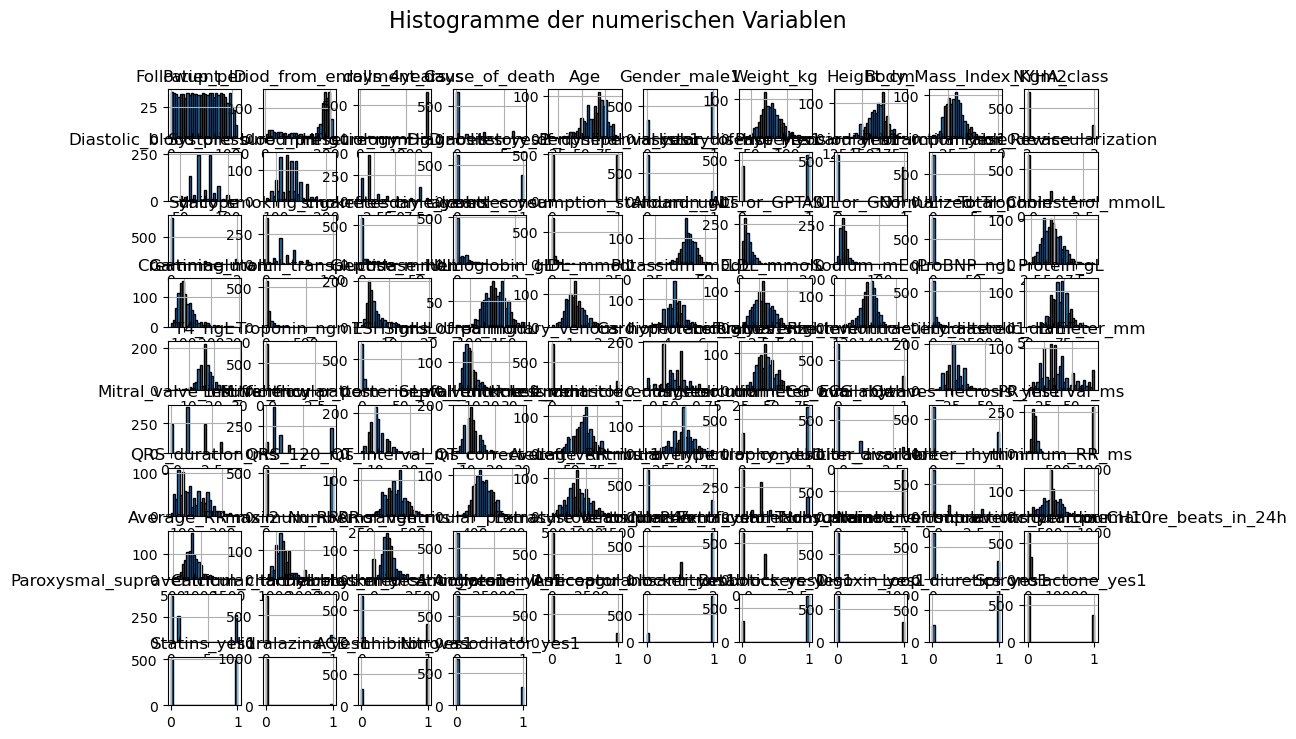

In [42]:
import matplotlib.pyplot as plt

# Histogramme für alle numerischen Spalten
df.hist(figsize=(12,8), bins=30, edgecolor='black')
plt.suptitle("Histogramme der numerischen Variablen", fontsize=16)
plt.show()


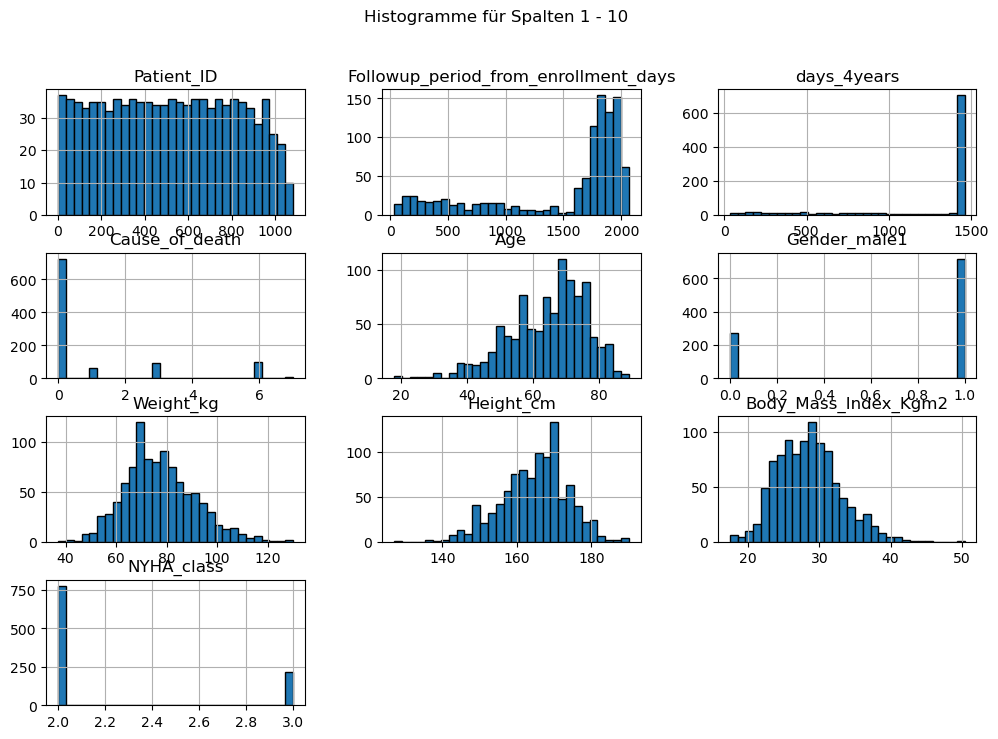

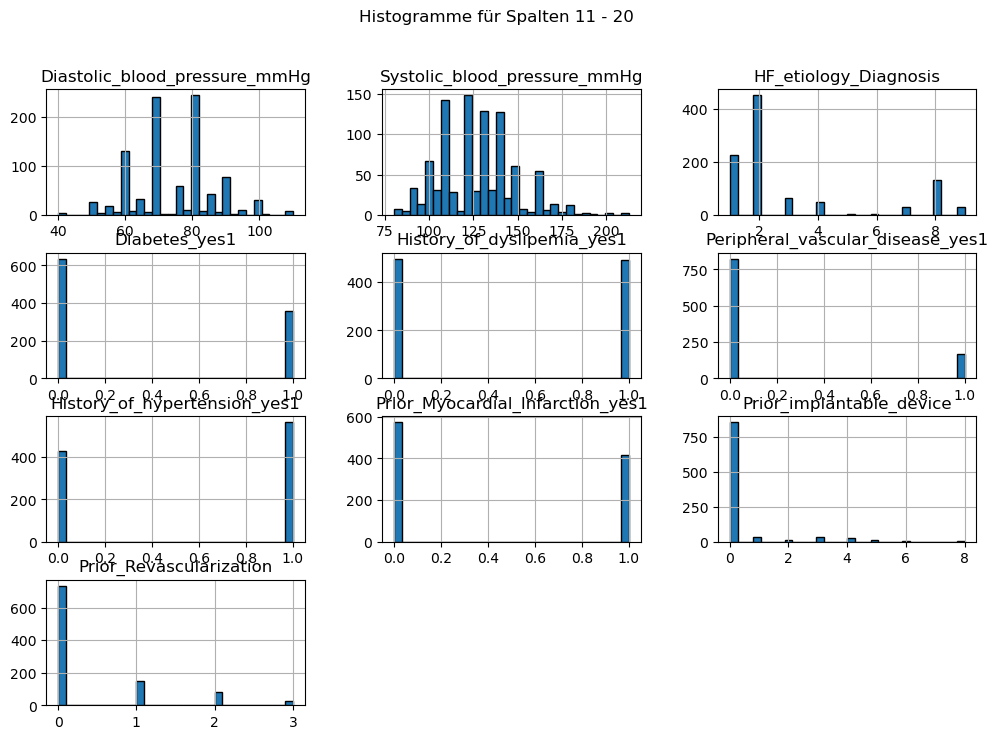

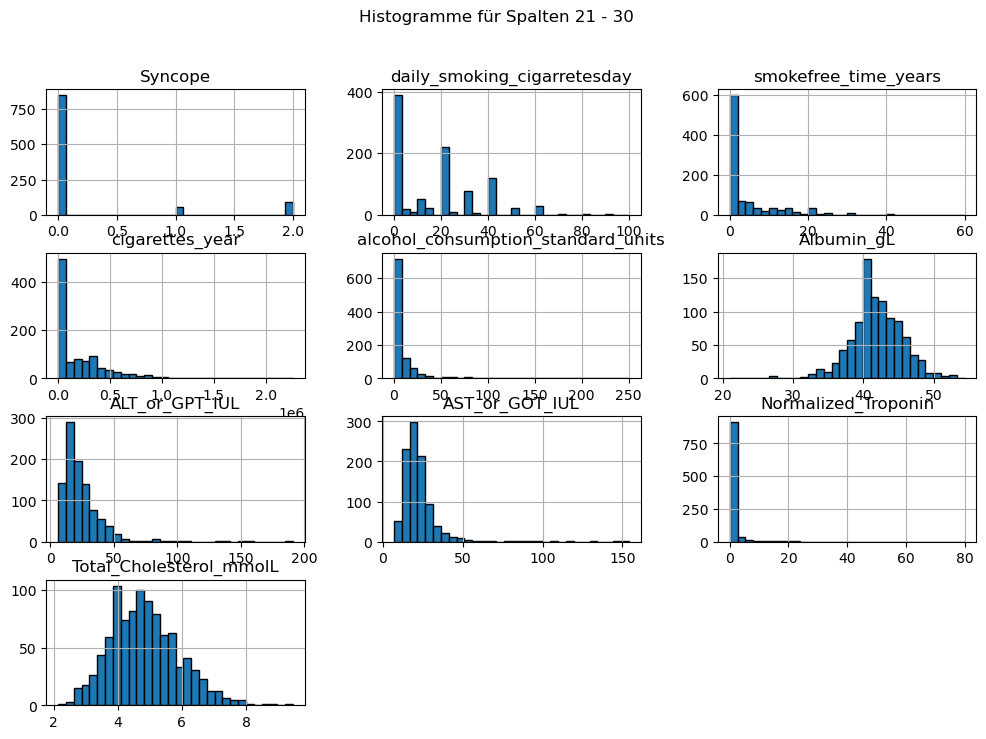

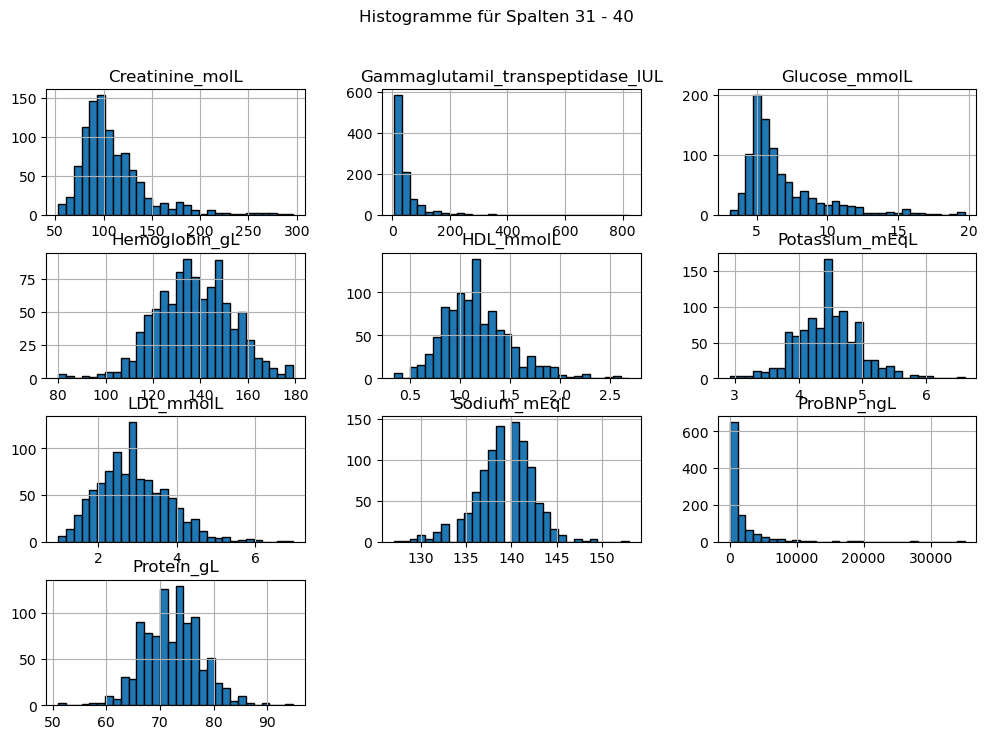

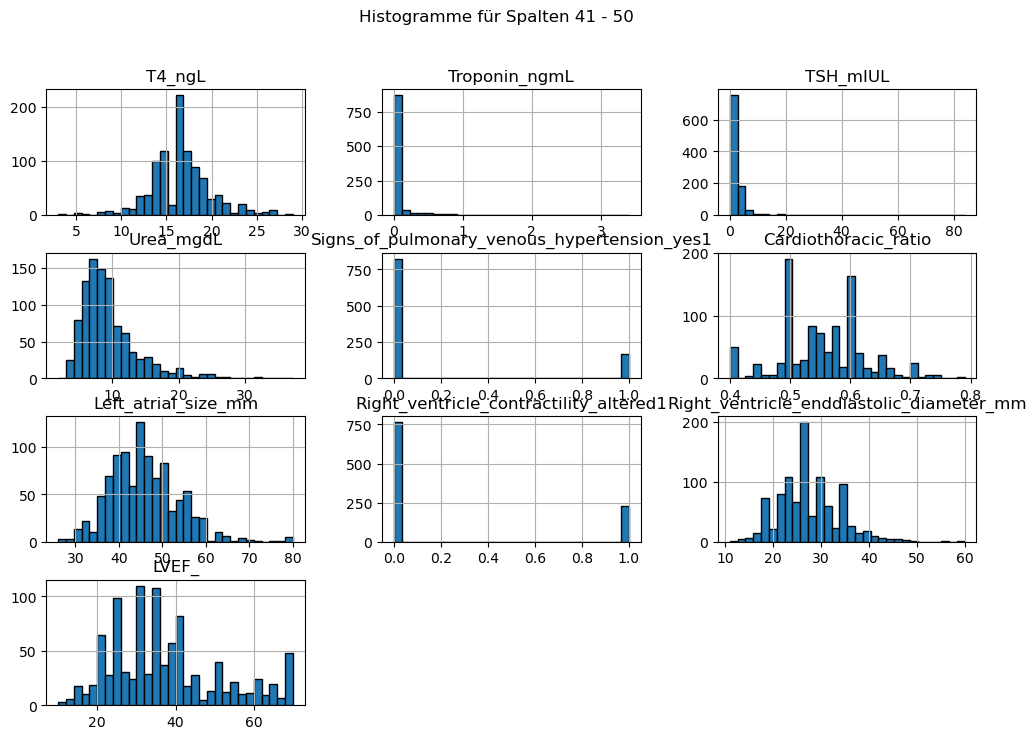

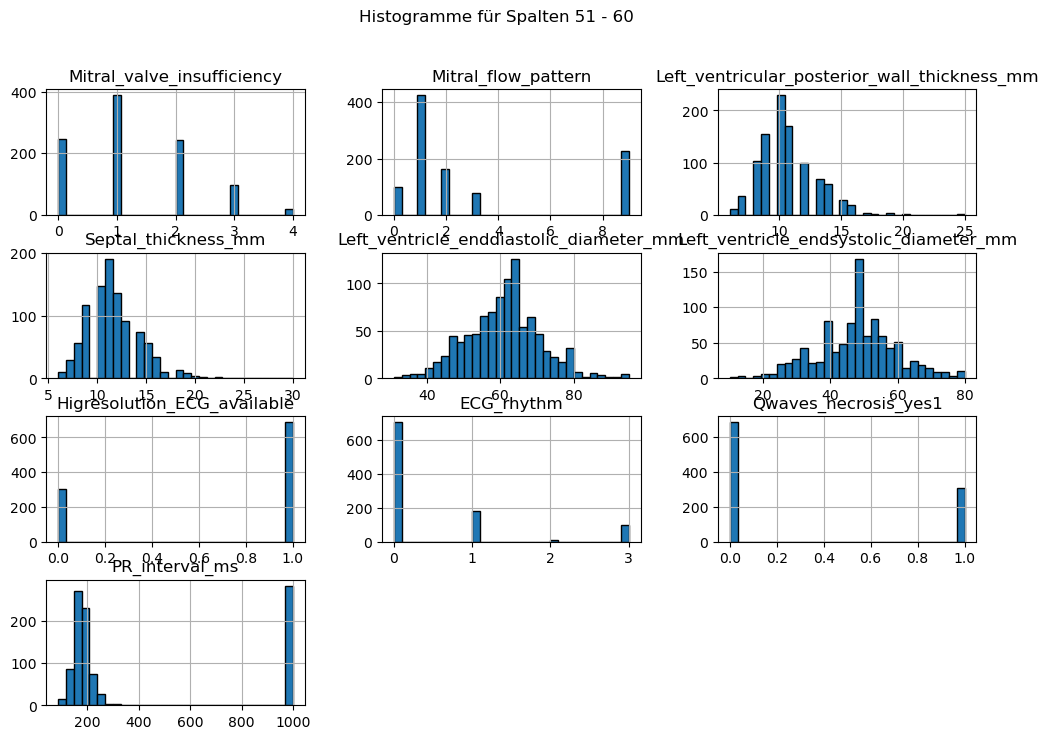

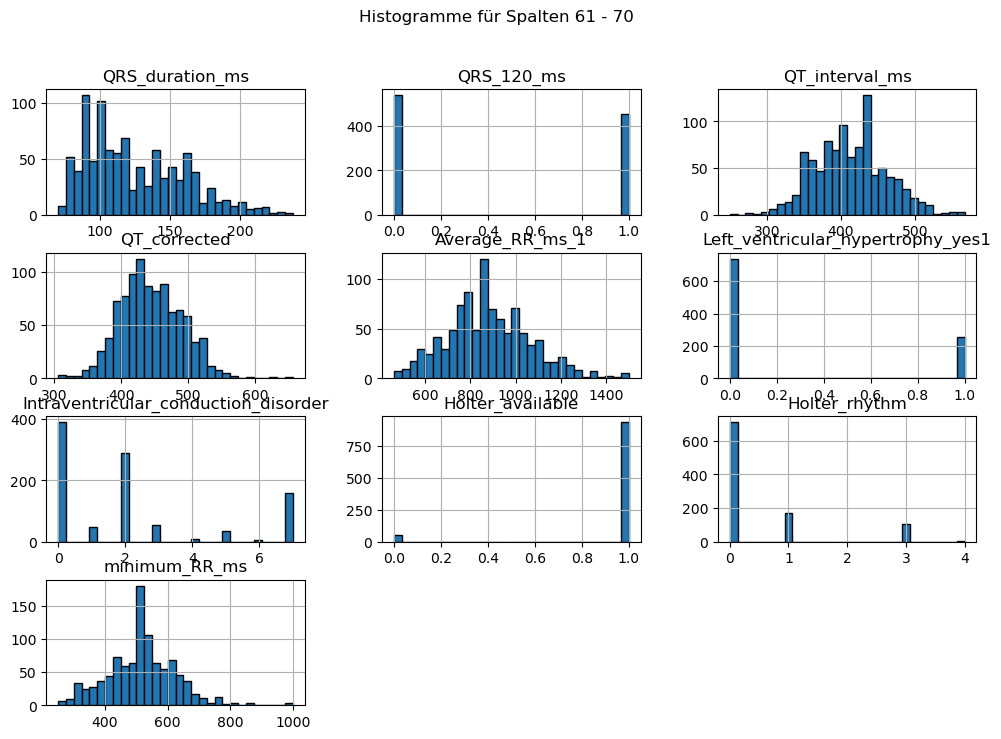

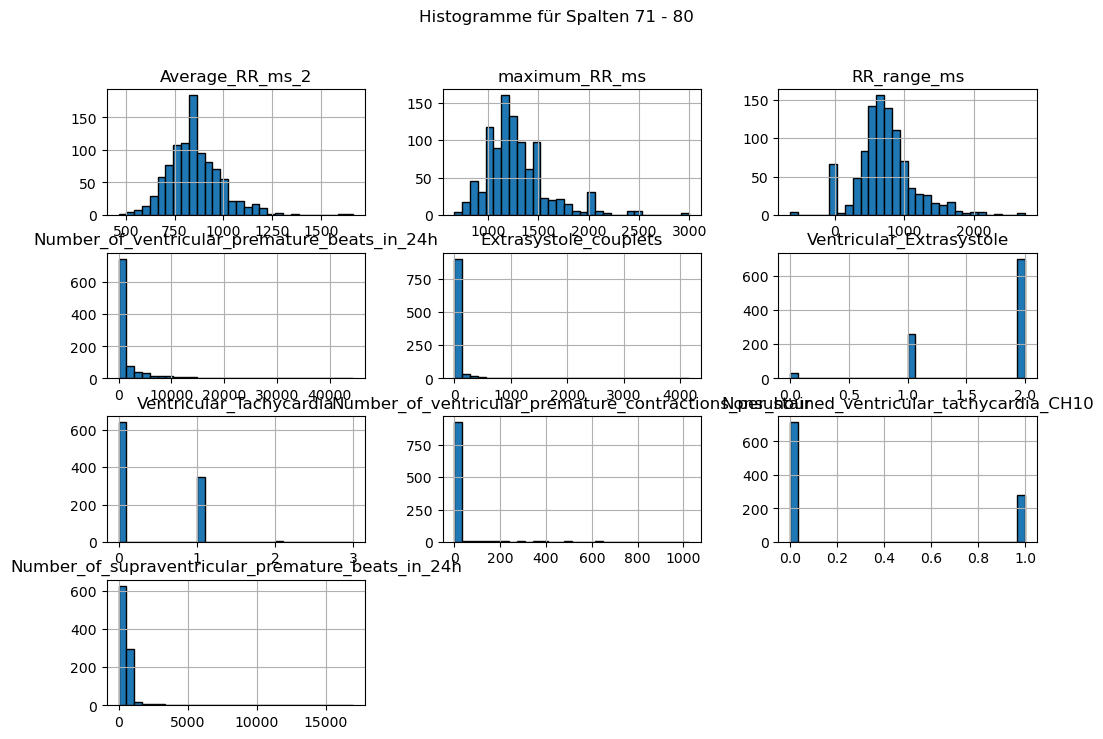

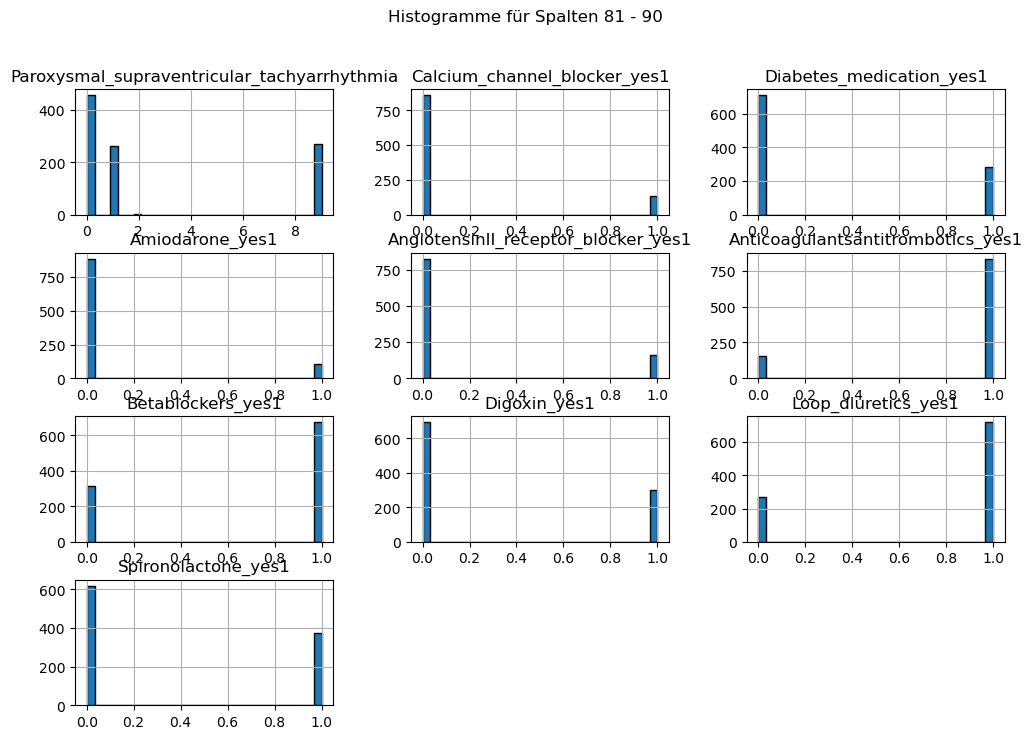

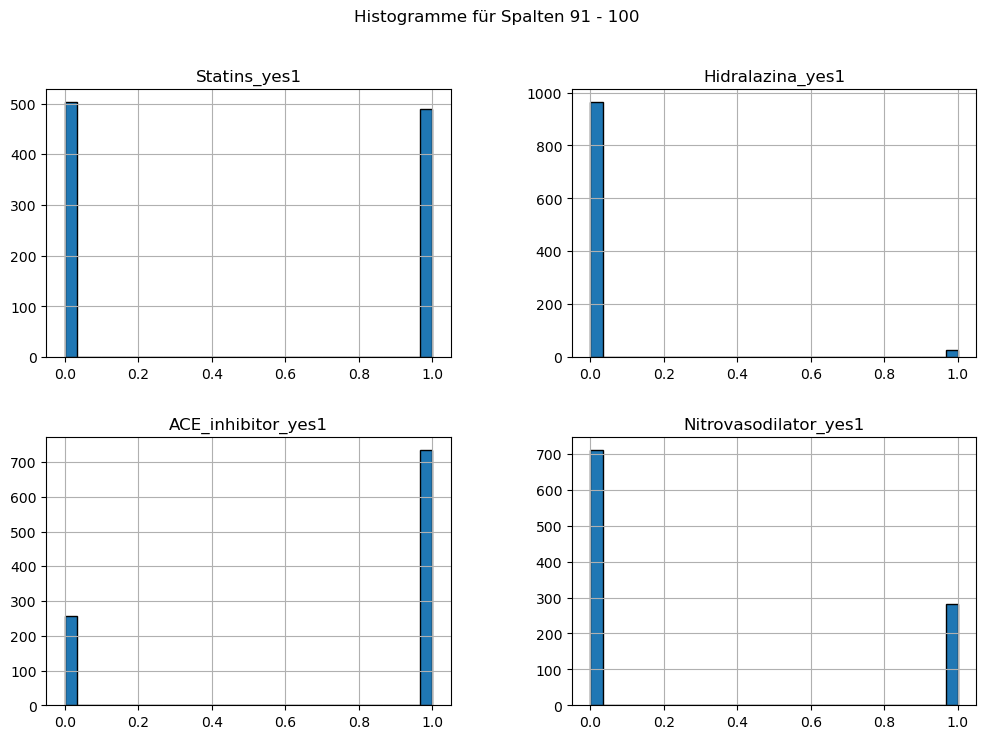

In [43]:
import numpy as np

# Histogramme in Gruppen anzeigen
num_features = df.select_dtypes(include=["float64", "int64"]).columns

# Teile die Variablen in Gruppen von 10 auf
for i in range(0, len(num_features), 10):
    subset = num_features[i:i+10]
    df[subset].hist(figsize=(12, 8), bins=30, edgecolor='black')
    plt.suptitle(f"Histogramme für Spalten {i+1} - {i+10}")
    plt.show()


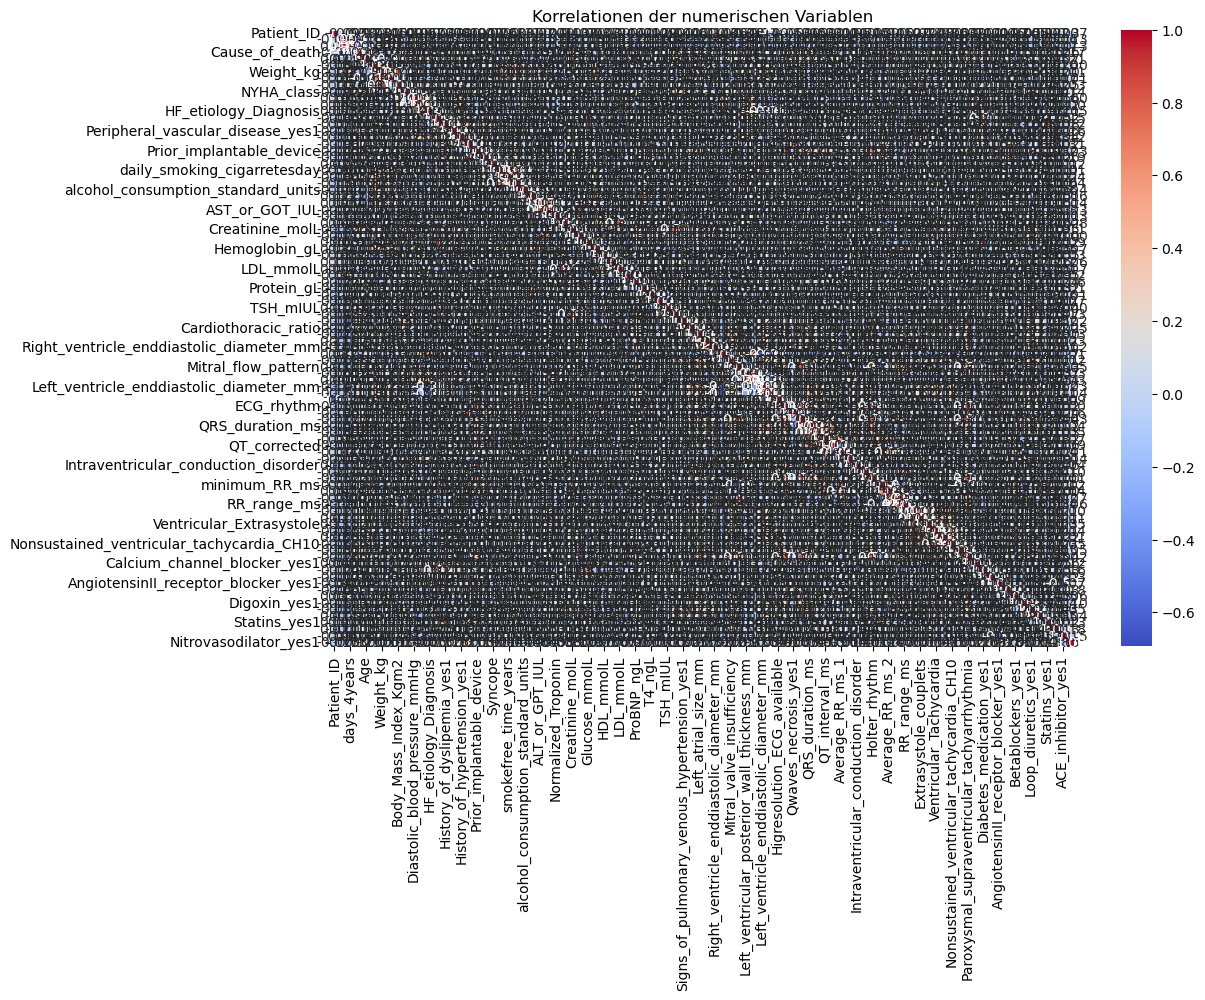

In [12]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korrelationen der numerischen Variablen")
plt.show()


In [ ]:
# Berechne die Korrelationen und sortiere sie absteigend
correlation_matrix = df.corr()
correlation_target = correlation_matrix["Cause_of_death"].sort_values(ascending=False)  # Zielvariable

print("Top 10 positiv korrelierte Variablen:")
print(correlation_target.head(10))

print("\nTop 10 negativ korrelierte Variablen:")
print(correlation_target.tail(10))


Top 10 positiv korrelierte Variablen:
Cause_of_death                            1.000000
Urea_mgdL                                 0.244389
Creatinine_molL                           0.239282
Left_atrial_size_mm                       0.223836
NYHA_class                                0.203841
ProBNP_ngL                                0.186795
Age                                       0.184975
Nitrovasodilator_yes1                     0.165931
Right_ventricle_contractility_altered1    0.147750
Peripheral_vascular_disease_yes1          0.147628
Name: Cause_of_death, dtype: float64

Top 10 negativ korrelierte Variablen:
Body_Mass_Index_Kgm2                   -0.089239
Average_RR_ms_1                        -0.095003
Sodium_mEqL                            -0.099411
Hemoglobin_gL                          -0.101961
LVEF_                                  -0.107505
Weight_kg                              -0.117290
Albumin_gL                             -0.129437
Betablockers_yes1                

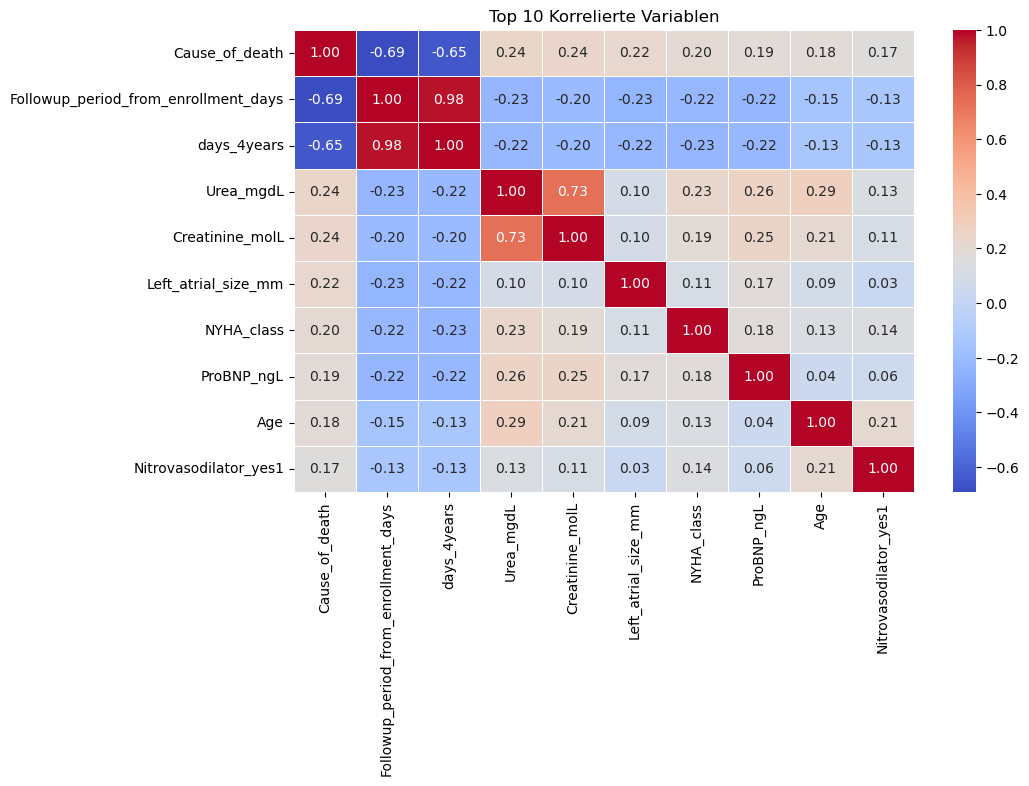

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wähle die 10 wichtigsten Features basierend auf ihrer Korrelation mit der Zielvariable
top_features = correlation_target.abs().sort_values(ascending=False).head(10).index

# Erstelle eine reduzierte Korrelationsmatrix
plt.figure(figsize=(10, 6))
sns.heatmap(df[top_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Top 10 Korrelierte Variablen")
plt.show()


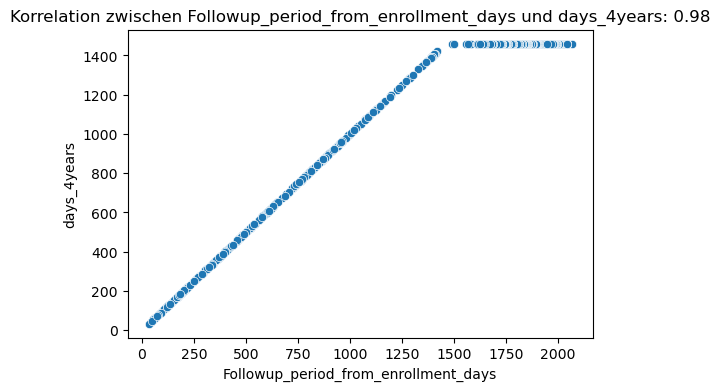

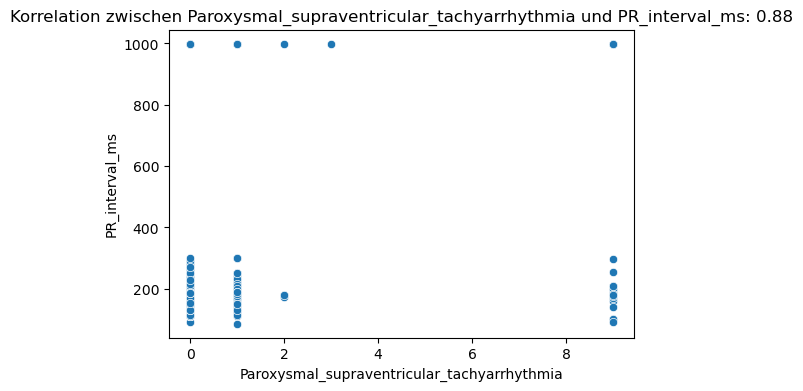

In [46]:
import seaborn as sns

# Wähle die beiden am stärksten korrelierten Variablen
top_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
top_corr_pairs = top_corr_pairs[top_corr_pairs < 1].drop_duplicates().head(2)  # Vermeidung von 1-Korrelation

for var1, var2 in top_corr_pairs.index:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[var1], y=df[var2])
    plt.title(f"Korrelation zwischen {var1} und {var2}: {top_corr_pairs[var1, var2]:.2f}")
    plt.show()


In [16]:
print(df.columns[df.columns.duplicated(keep=False)])


Index([], dtype='object')


print(df["Average_RR_ms"].head())


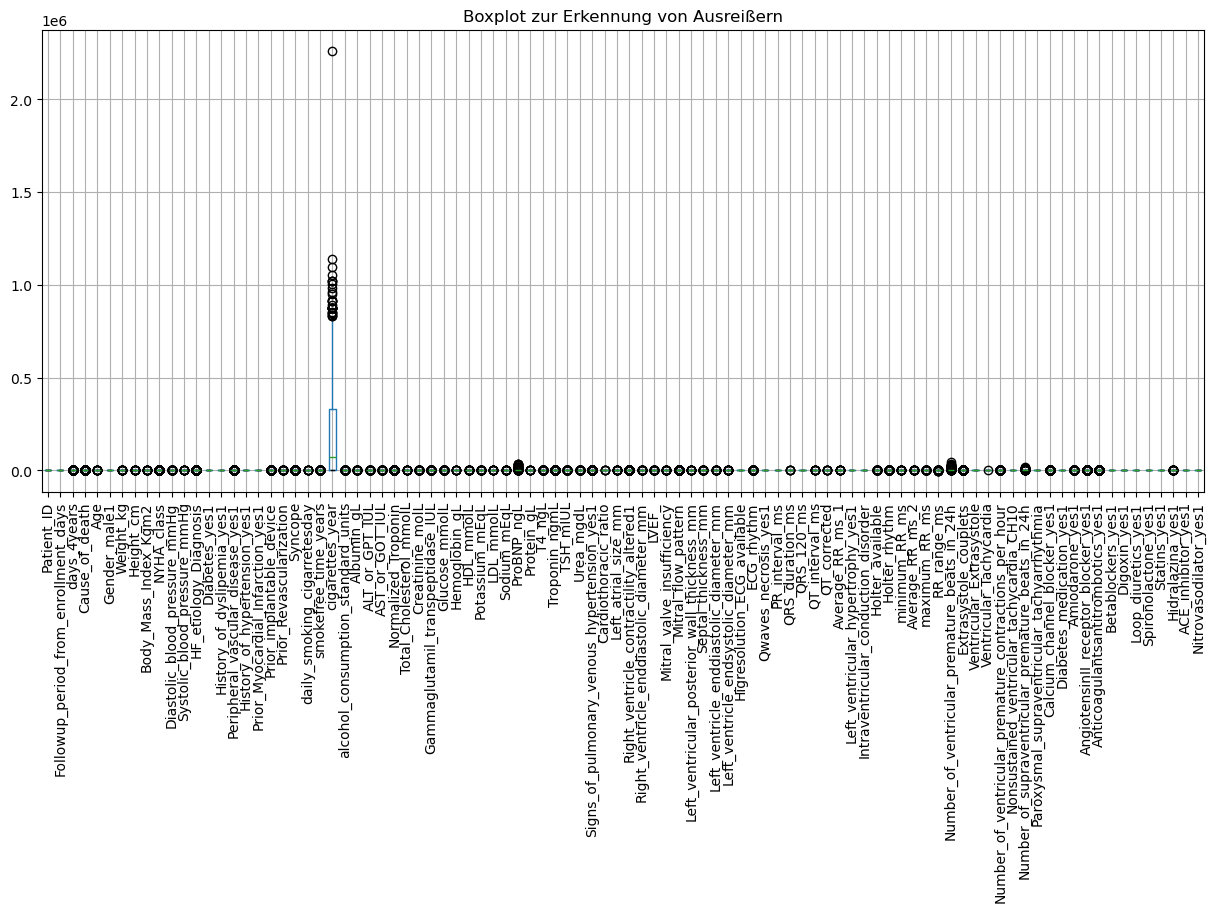

In [17]:
plt.figure(figsize=(15, 6))
df.boxplot(rot=90)  # Dreht Achsenbeschriftungen zur besseren Lesbarkeit
plt.title("Boxplot zur Erkennung von Ausreißern")
plt.show()


C:\Users\kthfu\AppData\Local\Temp\ipykernel_18024\861520104.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cause_of_death", data=df, palette="viridis")


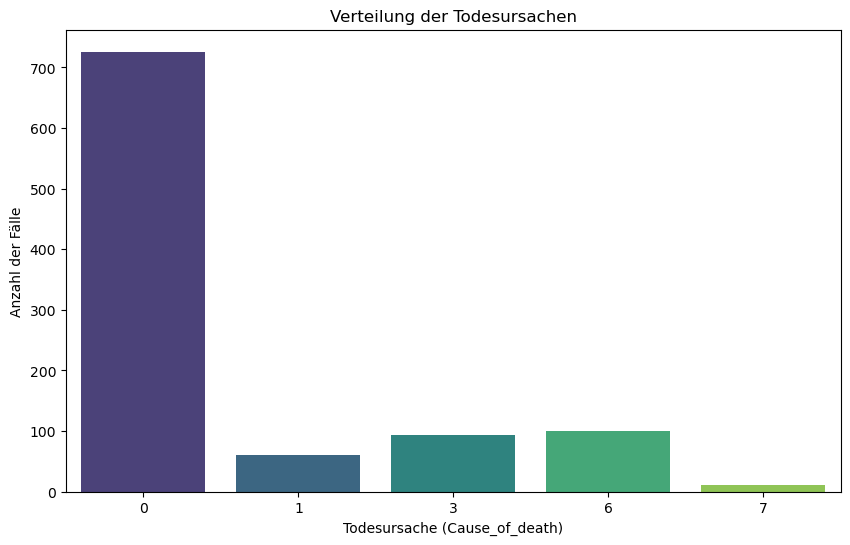

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(x="Cause_of_death", data=df, palette="viridis")
plt.title("Verteilung der Todesursachen")
plt.xlabel("Todesursache (Cause_of_death)")
plt.ylabel("Anzahl der Fälle")
plt.show()


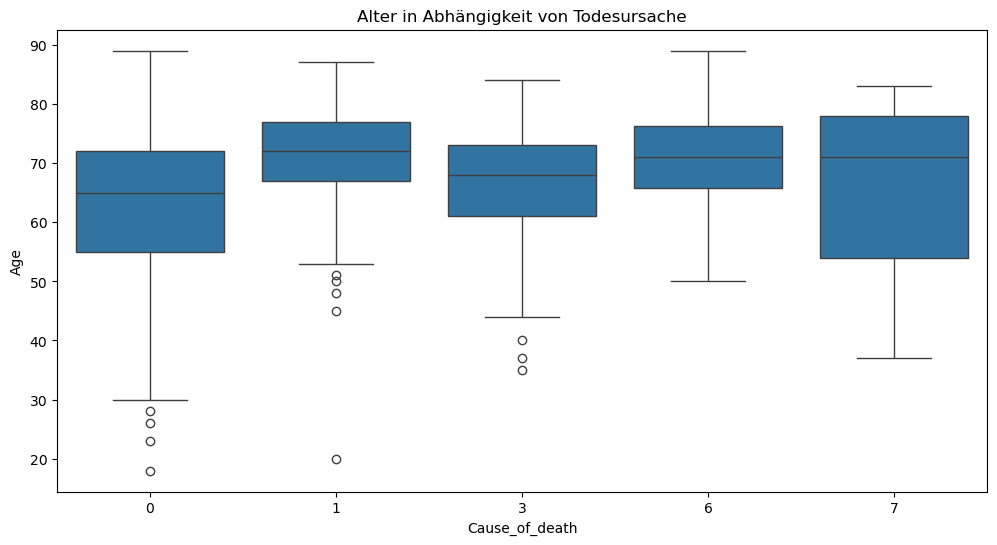

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cause_of_death", y="Age", data=df)
plt.title("Alter in Abhängigkeit von Todesursache")
plt.show()


In [47]:
# 1️⃣ Sicherstellen, dass alle möglichen Werte im Mapping enthalten sind
cause_mapping = {
    0: 0,  # Survivor
    1: 1,  # Non-Cardiac Death
    3: 2,  # Sudden Cardiac Death (SCD)
    6: 3,  # Pump Failure Death
    7: 3   # Pump Failure Death (gleiche Kategorie wie 6)
}

# 2️⃣ Mapping korrekt anwenden (VOR dem Split!)
df["Cause_of_death"] = df["Cause_of_death"].map(cause_mapping)

# 3️⃣ Falls NaN-Werte entstehen, sie durch eine Standardkategorie ersetzen
df["Cause_of_death"] = df["Cause_of_death"].fillna(-1)  # Falls unbekannte Werte da sind

# 4️⃣ Sicherstellen, dass alle Werte korrekt sind
print("Einzigartige Werte nach Mapping:", df["Cause_of_death"].unique())

# 5️⃣ Train/Test-Split durchführen (JETZT mit der korrekten Zielvariable)
X = df.drop(columns=["Cause_of_death"])  
y = df["Cause_of_death"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6️⃣ Überprüfen, ob die Werte korrekt in y_train und y_test übernommen wurden
print("y_train unique values:", y_train.unique())
print("y_test unique values:", y_test.unique())



Einzigartige Werte nach Mapping: [0 2 3 1]
y_train unique values: [0 3 2 1]
y_test unique values: [2 0 3 1]


In [48]:
from sklearn.model_selection import train_test_split

# Fehlende Werte in numerischen Spalten mit dem Median auffüllen
for col in df.select_dtypes(include=[np.number]):
    df[col] = df[col].fillna(df[col].median())

# Train/Test-Split durchführen
X = df.drop(columns=["Cause_of_death"])
y = df["Cause_of_death"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# Train- und Test-Daten speichern
train_path = "./data/train2.csv"
test_path = "./data/test2.csv"

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv(train_path, sep=";", encoding="utf-8", index=False)
test_data.to_csv(test_path, sep=";", encoding="utf-8", index=False)

# Ergebnisse anzeigen
{
    "Trainingsdaten gespeichert unter": train_path,
    "Testdaten gespeichert unter": test_path,
    "Form von X_train": X_train.shape,
    "Form von X_test": X_test.shape,
    "Anzahl Features nach Encoding": df.shape[1],
}

In [49]:
print("y_train unique values:", y_train.unique())
print("y_test unique values:", y_test.unique())


y_train unique values: [0 3 2 1]
y_test unique values: [2 0 3 1]


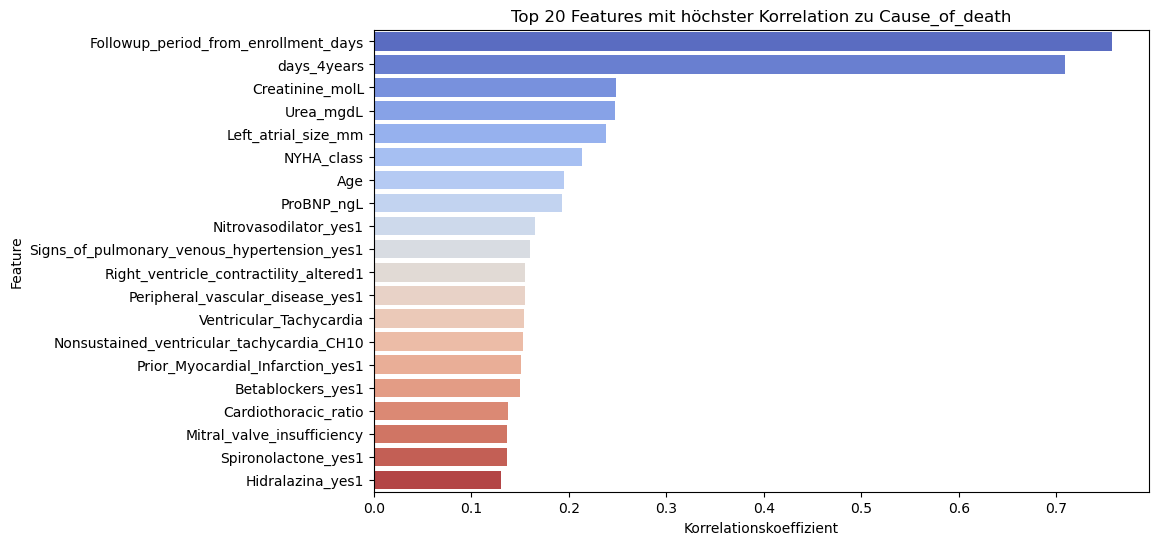

Followup_period_from_enrollment_days           0.756949
days_4years                                    0.709088
Creatinine_molL                                0.248190
Urea_mgdL                                      0.247883
Left_atrial_size_mm                            0.237923
NYHA_class                                     0.213361
Age                                            0.195221
ProBNP_ngL                                     0.192665
Nitrovasodilator_yes1                          0.164999
Signs_of_pulmonary_venous_hypertension_yes1    0.160433
Right_ventricle_contractility_altered1         0.154938
Peripheral_vascular_disease_yes1               0.154637
Ventricular_Tachycardia                        0.153611
Nonsustained_ventricular_tachycardia_CH10      0.152921
Prior_Myocardial_Infarction_yes1               0.151134
Betablockers_yes1                              0.150276
Cardiothoracic_ratio                           0.137275
Mitral_valve_insufficiency                     0

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korrelationen mit der Zielvariable "Cause_of_death" berechnen
corr_matrix = df.corr()
target_corr = corr_matrix["Cause_of_death"].drop("Cause_of_death")

# Stärkste positiven & negativen Korrelationen anzeigen
top_corr_features = target_corr.abs().sort_values(ascending=False).head(20)

# Visualisierung der Top-Features

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, hue=top_corr_features.index, palette="coolwarm", legend=False)
plt.xlabel("Korrelationskoeffizient")
plt.ylabel("Feature")
plt.title("Top 20 Features mit höchster Korrelation zu Cause_of_death")
plt.show()

# Ergebnisse anzeigen
top_corr_features

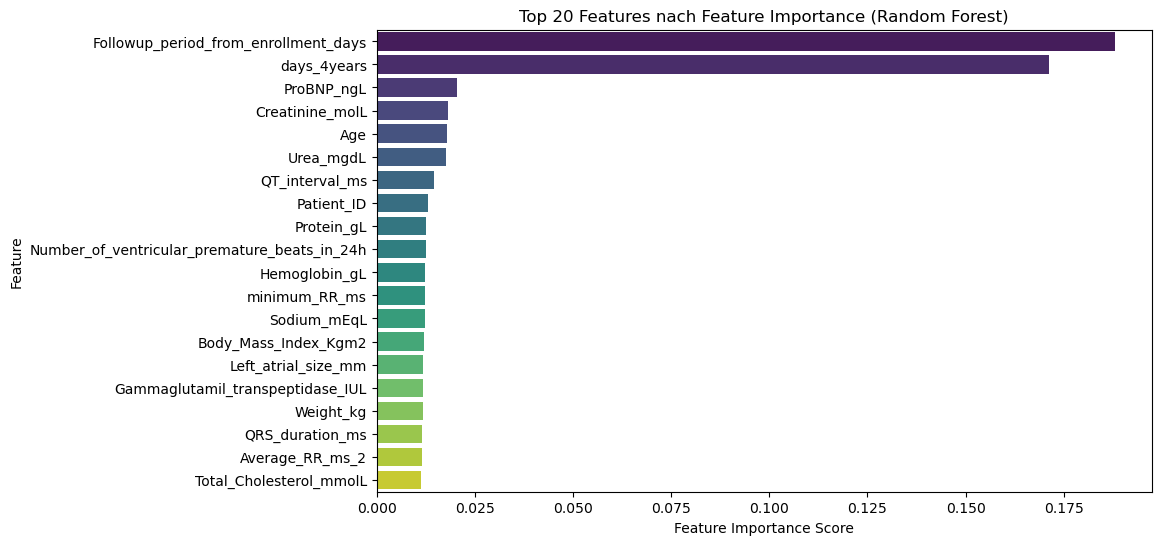

,Feature,Importance
1,Followup_period_from_enrollment_days,0.188021
2,days_4years,0.171202
37,ProBNP_ngL,0.020396
29,Creatinine_molL,0.018049
3,Age,0.017979
42,Urea_mgdL,0.017527
61,QT_interval_ms,0.014675
0,Patient_ID,0.013115
38,Protein_gL,0.012650
72,Number_of_ventricular_premature_beats_in_24h,0.012537


In [51]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Random Forest Modell initialisieren
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Modell mit Trainingsdaten trainieren
rf_model.fit(X_train, y_train)

# Feature Importances berechnen
feature_importances = rf_model.feature_importances_

# In DataFrame speichern und sortieren
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(20)

# Visualisierung der wichtigsten Features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df["Importance"], 
            y=feature_importance_df["Feature"], 
            hue=feature_importance_df["Feature"],  # `Feature` als `hue`, um die Warnung zu vermeiden
            palette="viridis", 
            legend=False)  # Deaktiviert die Legende, falls sie nicht benötigt wird
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Features nach Feature Importance (Random Forest)")
plt.show()



# Ergebnisse anzeigen
feature_importance_df

In [52]:
# Liste der wichtigsten Features aus der Feature Importance Analyse
top_features = feature_importance_df["Feature"].tolist()

# Train- und Testdaten auf die wichtigsten Features beschränken
X_train_filtered = X_train[top_features]
X_test_filtered = X_test[top_features]



# Ergebnisse anzeigen
{
   
    "Form von X_train (gefiltert)": X_train_filtered.shape,
    "Form von X_test (gefiltert)": X_test_filtered.shape,
}

{'Form von X_train (gefiltert)': (793, 20),
 'Form von X_test (gefiltert)': (199, 20)}

In [57]:
train_data_filtered = pd.concat([X_train_filtered, y_train], axis=1)
test_data_filtered = pd.concat([X_test_filtered, y_test], axis=1)


# Train- und Test-Daten erneut speichern
train_path_filtered = "./data/train_filtered2.csv"
test_path_filtered = "./data/test_filtered2.csv"

train_data_filtered = pd.concat([X_train_filtered, y_train], axis=1)
test_data_filtered = pd.concat([X_test_filtered, y_test], axis=1)

train_data_filtered.to_csv(train_path_filtered, sep=";", encoding="utf-8", index=False)
test_data_filtered.to_csv(test_path_filtered, sep=";", encoding="utf-8", index=False)

{
    "Trainingsdaten gespeichert unter": train_path_filtered,
    "Testdaten gespeichert unter": test_path_filtered,
    "Form von X_train (gefiltert)": X_train_filtered.shape,
    "Form von X_test (gefiltert)": X_test_filtered.shape,
}


In [58]:
print(y_train.head())  # Sollte die Zielvariable enthalten
print(y_test.head())


398    0
748    0
131    0
921    3
930    0
Name: Cause_of_death, dtype: int64
180    2
335    0
911    2
767    0
971    3
Name: Cause_of_death, dtype: int64


reverse_mapping = {0: "Survivor", 1: "Non-Cardiac Death", 2: "Sudden Cardiac Death (SCD)", 3: "Pump Failure Death"}
df["Cause_of_death_label"] = df["Cause_of_death"].map(reverse_mapping)

df[["Cause_of_death", "Cause_of_death_label"]].head()


In [59]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Modell initialisieren
model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)

# Modell trainieren
model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred = model.predict(X_test)

# Ergebnisse ausgeben
print(classification_report(y_test, y_pred))


c:\Users\kthfu\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:01:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       146
           1       0.50      0.25      0.33        12
           2       0.40      0.42      0.41        19
           3       0.52      0.50      0.51        22

    accuracy                           0.84       199
   macro avg       0.59      0.54      0.56       199
weighted avg       0.83      0.84      0.83       199



In [61]:
# Richtig: y_train und y_test wurden vorher schon definiert
y_train_filtered = y_train  # Verwende y_train direkt
y_test_filtered = y_test    # Verwende y_test direkt

# X_train_filtered und X_test_filtered sind bereits auf die Top-Features gefiltert
print("✅ Daten erfolgreich vorbereitet!")


✅ Daten erfolgreich vorbereitet!


In [62]:
print(y_train_filtered.head())  # Sollte Werte wie 0, 1, 2, 3 enthalten
print(y_test_filtered.head())


398    0
748    0
131    0
921    3
930    0
Name: Cause_of_death, dtype: int64
180    2
335    0
911    2
767    0
971    3
Name: Cause_of_death, dtype: int64


✅ Daten erfolgreich vorbereitet!


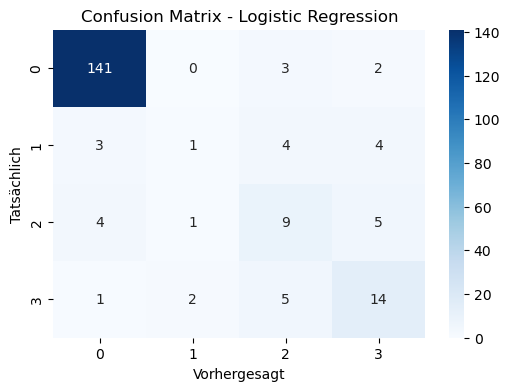

📊 Modell: Logistic Regression

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       146
           1       0.25      0.08      0.12        12
           2       0.43      0.47      0.45        19
           3       0.56      0.64      0.60        22

    accuracy                           0.83       199
   macro avg       0.55      0.54      0.53       199
weighted avg       0.81      0.83      0.82       199

--------------------------------------------------


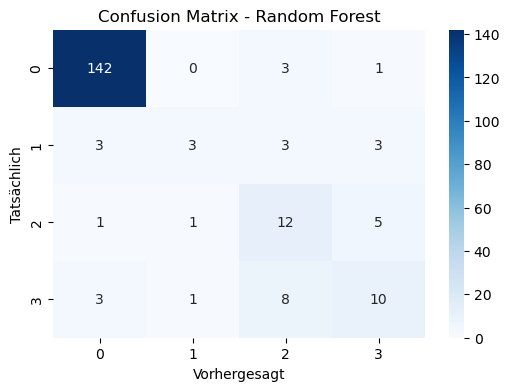

📊 Modell: Random Forest

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       146
           1       0.60      0.25      0.35        12
           2       0.46      0.63      0.53        19
           3       0.53      0.45      0.49        22

    accuracy                           0.84       199
   macro avg       0.64      0.58      0.58       199
weighted avg       0.84      0.84      0.83       199

--------------------------------------------------


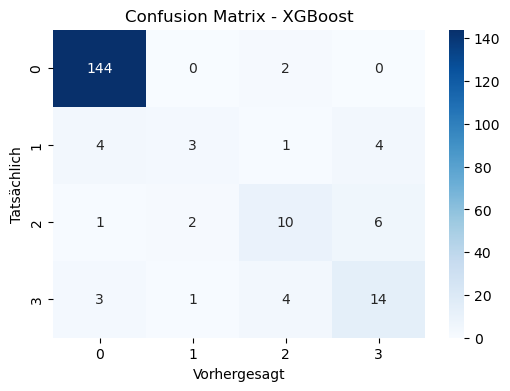

📊 Modell: XGBoost

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       146
           1       0.50      0.25      0.33        12
           2       0.59      0.53      0.56        19
           3       0.58      0.64      0.61        22

    accuracy                           0.86       199
   macro avg       0.65      0.60      0.62       199
weighted avg       0.85      0.86      0.85       199

--------------------------------------------------


{'Logistic Regression': {'Accuracy': 0.8291457286432161,
  'F1-Score': 0.8177009280082346},
 'Random Forest': {'Accuracy': 0.8391959798994975,
  'F1-Score': 0.8324435526203185},
 'XGBoost': {'Accuracy': 0.8592964824120602, 'F1-Score': 0.8494850806247298}}

In [66]:
# Erforderliche Bibliotheken importieren
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns



# Korrekte Definition der Zielvariablen (direkt aus y_train und y_test)
y_train_filtered = y_train  # Verwende y_train direkt
y_test_filtered = y_test    # Verwende y_test direkt

# X_train_filtered und X_test_filtered wurden bereits auf die Top-Features gefiltert
print("✅ Daten erfolgreich vorbereitet!")



# Modelle initialisieren
models = {
    "Logistic Regression": LogisticRegression(solver="saga", max_iter=5000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42)
}

# Training und Evaluation
results = {}

for model_name, model in models.items():
    # Modell trainieren
    model.fit(X_train_filtered, y_train_filtered)
    
    # Vorhersagen erstellen
    y_pred = model.predict(X_test_filtered)
    
    # Metriken berechnen
    accuracy = accuracy_score(y_test_filtered, y_pred)
    f1 = f1_score(y_test_filtered, y_pred, average="weighted")
    
    # Ergebnisse speichern
    results[model_name] = {"Accuracy": accuracy, "F1-Score": f1}
    
    # Confusion Matrix visualisieren
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test_filtered, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Tatsächlich")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # Klassifikationsbericht ausgeben
    print(f"📊 Modell: {model_name}\n")
    print(classification_report(y_test_filtered, y_pred))
    print("-" * 50)

# Ergebnisse anzeigen
results